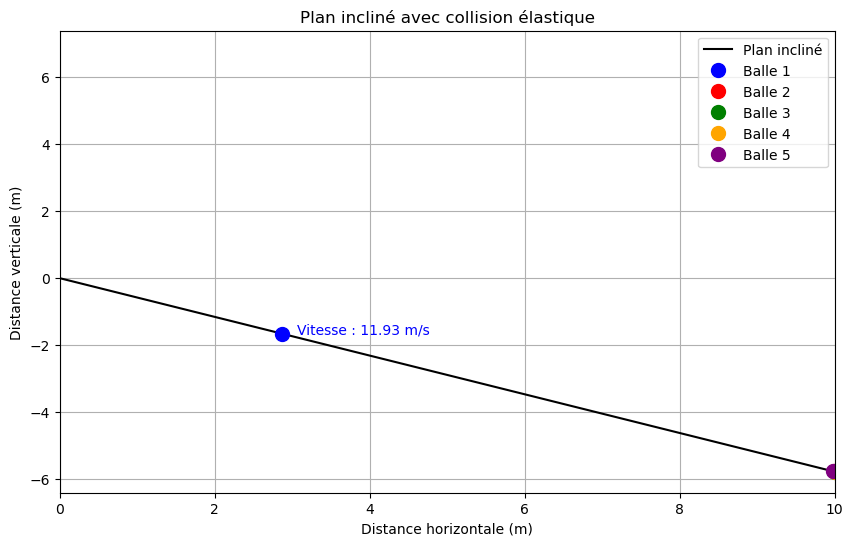

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

# Physical settings
g = 9.81 # Gravitational acceleration (m/s^2)
theta = np.radians(30) # Angle of inclination of plane (30 degrees)
L = 10 # Length of inclined plane (m)
dt = 0.01 # Time step (s)
m = [1.0] * 5 # Masses of balls (equal)
e = 1.0 # Coefficient of restitution (1 = perfectly elastic collision)

# Components of acceleration
a_x = [g * np.sin(theta) * (1 / (i + 1)) for i in range(5)]

# Simulation for a fixed number of steps
steps = int(L / (0.5 * max(a_x) * dt**2)) + 1
t = np.arange(steps) * dt

# Calculation of initial positions and speeds
x = [0.5 * a * t**2 + 2 * i for i, a in enumerate(a_x)]
vx = [a * t for a in a_x]

#collision management
def handle_collision(x, vx, i, j, collision_index):
    v1_new = ((m[i] - e*m[j])*vx[i][collision_index] + (1 + e)*m[j]*vx[j][collision_index])/(m[i] + m[j])
    v2_new = ((1 + e)*m[i]*vx[i][collision_index] + (m[j] - e*m[i])*vx[j][collision_index])/(m[i] + m[j])
    
    vx[i][collision_index:] = v1_new + a_x[i] * (t[:len(vx[i][collision_index:])] - t[collision_index])
    vx[j][collision_index:] = v2_new + a_x[j] * (t[:len(vx[j][collision_index:])] - t[collision_index])
    
    x[i][collision_index:] = x[i][collision_index] + np.cumsum(vx[i][collision_index:] * dt)
    x[j][collision_index:] = x[j][collision_index:] + np.cumsum(vx[j][collision_index:] * dt)
    return x, vx

for i in range(5):
    for j in range(i + 1, 5):
        collision_indices = np.where(np.abs(np.array(x[i]) - np.array(x[j])) < 0.1)[0]
        if len(collision_indices) > 0:
            collision_index = collision_indices[0]
            if collision_index < steps - 1:
                x, vx = handle_collision(x, vx, i, j, collision_index)

# Calculation of vertical positions
y = [-np.tan(theta) * np.array(x[i]) for i in range(5)]

# Limit tables to valid positions
valid_indices = [np.array(x[i]) <= L for i in range(5)]
x = [np.array(x[i])[valid_indices[i]] for i in range(5)]
y = [np.array(y[i])[valid_indices[i]] for i in range(5)]
vx = [np.array(vx[i])[valid_indices[i]] for i in range(5)]

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, L)

# Configuration of vertical limits
y_min, y_max = min([y[i].min() for i in range(5)]), max([y[i].max() for i in range(5)])
margin = 0.05 * (y_max - y_min) if y_max > y_min else 0.1
ax.set_ylim(y_min - margin, y_max + margin)

# Axis and title configuration
ax.set_xlabel("Distance horizontale (m)")
ax.set_ylabel("Distance verticale (m)")
ax.set_title("Plan incliné avec collision élastique")
ax.grid(True)

# Tracé du plan incliné
plan_x = np.linspace(0, L, 100)
plan_y = -np.tan(theta) * plan_x
ax.plot(plan_x, plan_y, 'k-', label="Plan incliné")

# Inclined plane layout
colors = ['blue', 'red', 'green', 'orange', 'purple']
points = [ax.plot([], [], 'o', color=colors[i], markersize=10, label=f"Balle {i+1}")[0] for i in range(5)]
ax.legend()

def init():
    for point in points:
        point.set_data([], [])
    return points

def update(frame):
    for txt in ax.texts:
        txt.remove()

    all_out = True # Checks if all bullets are out
    for i, point in enumerate(points):
        if frame < len(x[i]):
            point.set_data([x[i][frame]], [y[i][frame]])
            ax.text(x[i][frame] + 0.2, y[i][frame], 
                    f'Vitesse : {vx[i][frame]:.2f} m/s',
                    color=colors[i])
            all_out = False # If a ball is still on the plane, we continue
    
    if all_out:
        ani.event_source.stop() # Stop animation if all balls are out

    return points


# Calculate total number of frames for animation to last 30 seconds
fps = 30 # Frame rate per second
duration = 30 # Duration in seconds
frames = duration * fps # Total number of frames

# Reduce number of frames if necessary (depending on simulation length)
max_frames = max(len(x[i]) for i in range(5))
frames = min(frames, max_frames)

# Animation creation
ani = FuncAnimation(fig, update, frames=frames, init_func=init, 
                   blit=False, interval=(1000 / fps))

# Save animation as MP4
writer = FFMpegWriter(fps=fps, bitrate=2500)
ani.save("collision_elastique_plan_incline_30s.mp4", writer=writer)

plt.show()

